# **CS-542 Principles of Machine Learning Common Task Report**
### **Submitted by: Akshat Gurbuxani (U80105862)**

## **Introduction**

The subsequent report delineates the common task in which we were tasked with developing a machine learning model for forecasting a city's daily highest weather temperature. Moreover, our objective encompassed automating betting activities through Kalshi's API and their demo interface.

## **MANUAL TRADING**

On September 25 and 26, the common task officially started by manually trading maximum daytime temperatures for New York, Miami, and Chicago. Both few correct and few incorrect bets were placed. Overall, I became accustomed to the Kalshi platform and realized how unpredictable the process was. Below shown are some screenshots of those bets.

In [2]:
from IPython.display import display, Image


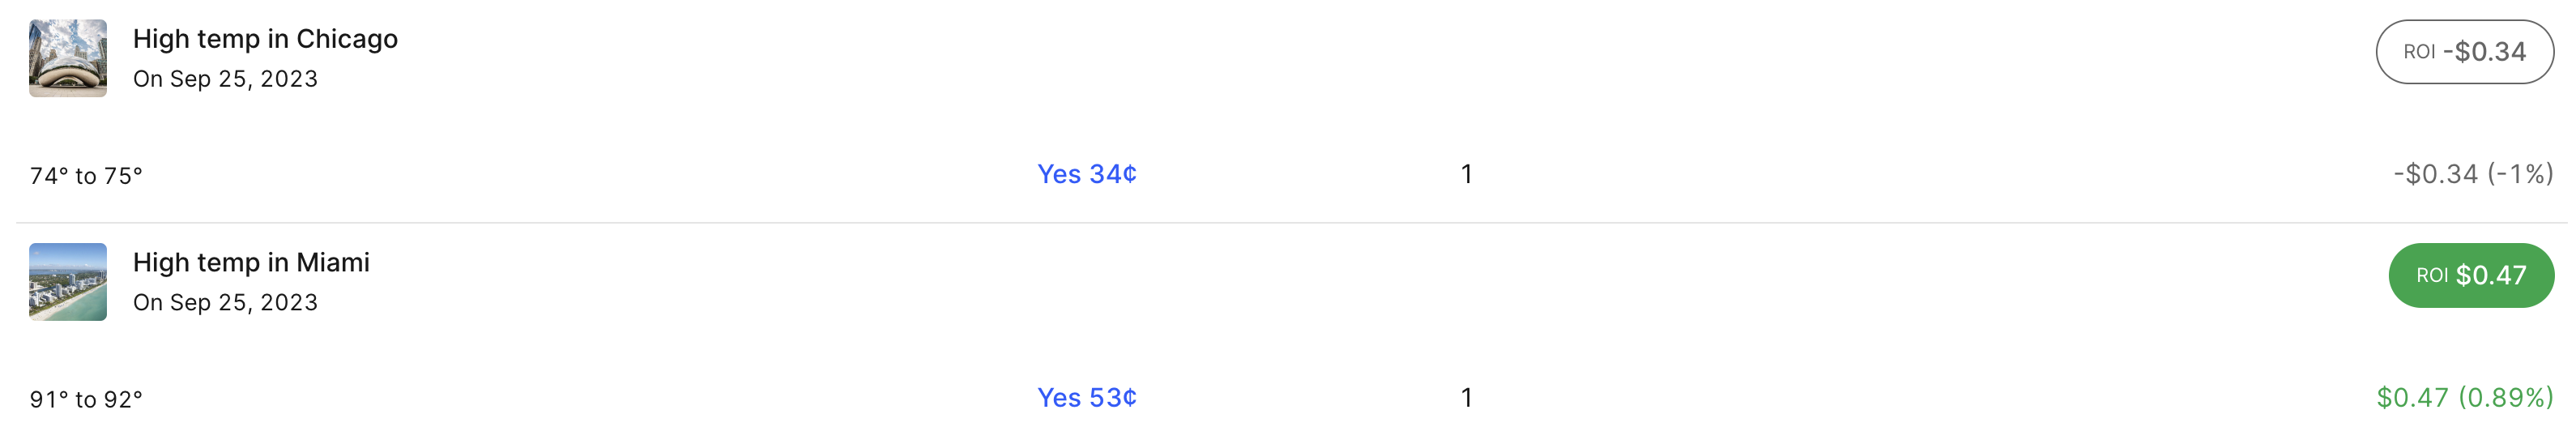

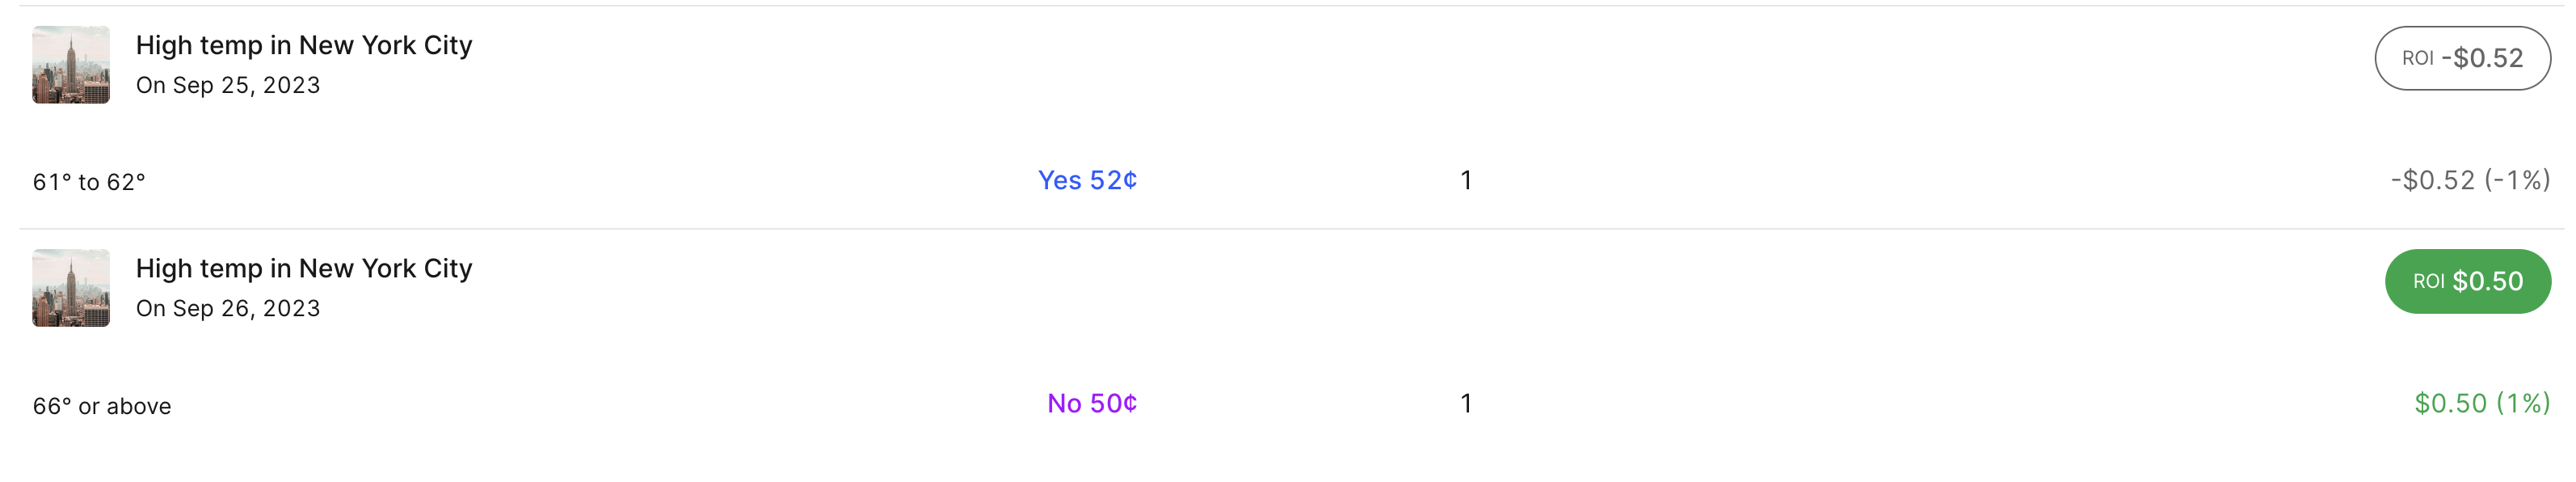

In [135]:
image_01 = Image("Screenshot/image_01.png")
image_02 = Image("Screenshot/image_02.png")
display(image_01, image_02)

## **DATA SCRAPING**

Finding data and formatting it into usable information was the following stage. Here, I used "robots.txt" to obtain useful data by using several distinct websites. Additionally, I realized that New York has the largest dataset readily available, so I chose to make that the target city. Five such webpages are listed below.

#### National Oceanic and Atmospheric Administration(NOAA)
This was the first and most obvious option, but NOAA doesn't give us the most recent weather information. Later, NOAA dataset was determined to be the best option for model training. We used a separate website, for prediction. Additionally, NOAA doesn't offer hourly data.

#### Visual Crossing
This was the option chosen in the end to forecast the highest day temperature. It offers hourly and the most recent data. The main limitation is that we can only retrieve 1000 records every day. This is insufficient to train the model.

#### OpenWeatherMap
In order to access the historical api, I had to pay. As a result, this website was removed.

#### National Weather Service(NWS)
This only offered a small amount of recent historical data. This wasn't sufficient to train a model.

#### Weather by IBM
I had to remove this option because I was unable to obtain enough historical weather data.

## **MODEL TRAINING**

I used the XGBoost alogrithm which is an open-source software library which provides a regularizing gradient boosting framework. NOAA's historical weather data from the year 2000 is used to train the model.

In [106]:
import pandas as pd
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import pickle

In [124]:

df = pd.read_csv('Data/centalpark_from2000.csv')
# df.head()

# Adding only required features for training
df = df[['DATE', 'TMAX', 'TMIN']]
# df.head()

# Formatting to 'DateTime' and adding day and month as feature
df['DATE'] = pd.to_datetime(df['DATE'])
df['day'] = df['DATE'].dt.day
df['month'] = df['DATE'].dt.month
df.sort_values(by = ['DATE'], inplace = True)

# Creating rolling windows for TMAX AND TMIN features

# Historical TMAX features
for window in [10, 7, 3, 2, 1]:
    df[f'TMAX_prev{window}'] = df['TMAX'].rolling(window, closed = 'left').max()

# Historical TMIN features
for window in [7, 3, 2, 1]:
    df[f'TMIN_prev{window}'] = df['TMIN'].rolling(window, closed = 'left').min()


# Removing the first 10 rows to avoid NaN values
df = df.loc[10:, :]

# Replacing null values with 0, if any
if(df.isna().values.any()):
    df.fillna(0, inplace = True)

# Removing real time feature
df.drop(['TMIN'], axis = 1, inplace = True)

# Assigning the training and the testing split
train_df = df[df['DATE'] < '2023-08-01']
test_df = df[df['DATE'] >= '2023-08-01']

train_df.set_index("DATE", inplace = True)
test_df.set_index("DATE", inplace = True)

X_train, X_test, y_train, y_test = train_df.drop(['TMAX'], axis = 1).values, test_df.drop(['TMAX'], axis = 1).values, train_df['TMAX'].values, test_df['TMAX'].values 


# XGBoost regressor model
model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Finding MAE
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.3f}')


Mean Absolute Error: 3.437


In [125]:
# Dumping data to local
file_path = "Model/xgb_model.pkl"
pickle.dump(model, open(file_path, "wb"))

## **Visualizing the model's efficiency**

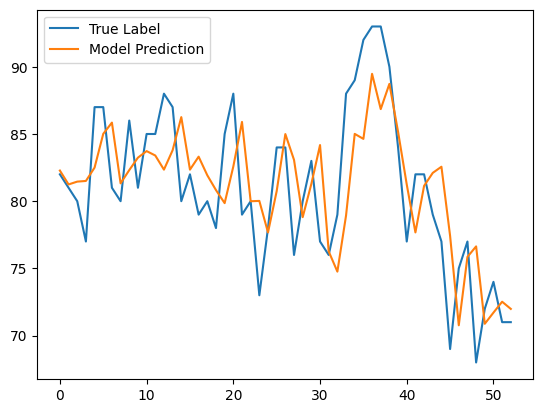

In [126]:
plt.plot(y_test, label = 'True Label')
plt.plot(y_pred, label = 'Model Prediction')
plt.legend()
plt.show()

## **AUTOMATED TRADING**

I used the Kalshi demo API to automate the betting process. The process involves the following steps.
1. Load the required model to make prediction
2. Use Kalshi demo API to fetch the data and filter it by state and date.
3. Use the model to anticipate the day's highest temperature, then wager "No" on the farthest range of temperatures to maximize the profit. 

In [127]:

from KalshiClientsBaseV2 import ExchangeClient
import pandas as pd
import numpy as np
import uuid
import urllib.request
import pickle

In [129]:

# Loading credentials
demo_email = "user_email" 
demo_password = "user_password" 
demo_api_base = "https://demo-api.kalshi.co/trade-api/v2"
ticker_name = "HIGHNY-23OCT11"

# Initializing exchage client
exchange_client = ExchangeClient(exchange_api_base = demo_api_base, email = demo_email, password = demo_password)

#Fetching data through api
api_key = "user_api_key"
url = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/Central%20Park%20New%20York/2023-09-20/2023-10-08?unitGroup=us&maxDistance=1000&include=days&key={api_key}&elevationDifference=1&contentType=csv'
destination = '../Data/infer_temp.csv'
urllib.request.urlretrieve(url, destination)

weather_df = pd.read_csv(destination)

# Fetching the model
file = open("Model/xgb_model.pkl",'rb')
predictive_model = pickle.load(file)
file.close()

def fetch_ticker_market(event_ticker):

    market_params = {'limit':200,
                        'cursor':None, # passing in the cursor from the previous get_markets call
                        'event_ticker': event_ticker,
                        'series_ticker':None,
                        'max_close_ts':None, # pass in unix_ts
                        'min_close_ts':None, # pass in unix_ts
                        'status':None,
                        'tickers':None}
    
    markets_response = exchange_client.get_markets(**market_params)

    return markets_response['markets']

def extract_temperatures_and_tickers(markets):

    # Lists to store temperature values and corresponding tickers
    temperatures = []
    tickers = []

    for market in markets:
        # Split the subtitle into tokens
        subtitle_tokens = market['subtitle'].split()

        if "to" in subtitle_tokens:
            # Extract two temperature values
            temperature1 = int(subtitle_tokens[0][:-1])
            temperature2 = int(subtitle_tokens[-1][:-1])

            # Calculate the average temperature
            average_temperature = (temperature1 + temperature2) / 2
            temperatures.append(average_temperature)

            # Store the associated ticker
            tickers.append(market['ticker'])

        else:
            # Extract the single temperature value
            temperature = int(subtitle_tokens[0][:-1])
            temperatures.append(temperature)

            # Store the associated ticker
            tickers.append(market['ticker'])
            

    return temperatures, tickers
    
def place_trade_order(ticker, side, count = 10, type = 'market'):

    order_params = {'ticker':ticker,
                    'client_order_id':str(uuid.uuid4()),
                    'type':type,
                    'action':'buy',
                    'side':side,
                    'count':count,
                    'expiration_ts':None,
                    'sell_position_floor':None,
                    'buy_max_cost':None}

    exchange_client.create_order(**order_params)


def predict_maximum_temperature(model, df):

    df.rename(columns = {'datetime':'DATE', 'tempmax':'TMAX', 'tempmin':'TMIN'}, inplace = True)

    df = df[['DATE', 'TMAX', 'TMIN']]

    # Formatting to 'DateTime' and adding day and month as feature
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['day'] = df['DATE'].dt.day
    df['month'] = df['DATE'].dt.month
    df.sort_values(by = ['DATE'], inplace = True)
    df.set_index("DATE", inplace = True)

    # Creating rolling windows for TMAX and TMIN features

    # Historical TMAX features
    for window in [10, 7, 3, 2, 1]:
        df[f'TMAX_prev{window}'] = df['TMAX'].rolling(window).max()

    # Historical TMIN features
    for window in [7, 3, 2, 1]:
        df[f'TMIN_prev{window}'] = df['TMIN'].rolling(window).min()

 
    # Removing first 10 rows because of rolling window of size 10
    df = df.iloc[10:, :]
    
    # Replacing null values with 0, if any
    if(df.isna().values.any()):
        df.fillna(0, inplace = True)

    # Removing real time feature
    df.drop(['TMIN', 'TMAX'], axis = 1, inplace = True)

    return model.predict(df)[-1]

# Predict maximum temperature
predicted_temperature = predict_maximum_temperature(predictive_model, weather_df)
print(f"Predicted Maximum Temperature: {predicted_temperature:.3f}", '\n')

# Fetch market data
market_data = fetch_ticker_market(ticker_name)

# Find the market with the temperature range closest to the predicted value
temperatures, ticker_names = extract_temperatures_and_tickers(market_data)
closest_market_index = np.argmax(abs(np.array(temperatures) - predicted_temperature))

# Place a trade order for the selected market
print(f'Placing the trade order\n')
place_trade_order(ticker_names[closest_market_index], "no", 400)



/var/folders/17/k1tgc2q128b96ylqbtj7ts2c0000gn/T/ipykernel_20057/1749227537.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATE'] = pd.to_datetime(df['DATE'])
/var/folders/17/k1tgc2q128b96ylqbtj7ts2c0000gn/T/ipykernel_20057/1749227537.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df['DATE'].dt.day
/var/folders/17/k1tgc2q128b96ylqbtj7ts2c0000gn/T/ipykernel_20057/1749227537.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

Predicted Maximum Temperature: 62.097 

Placing the trade order



## **Conclusion**

There were many bets made. While some were accurate, some weren't. The wagers made directly by the model are displayed here.

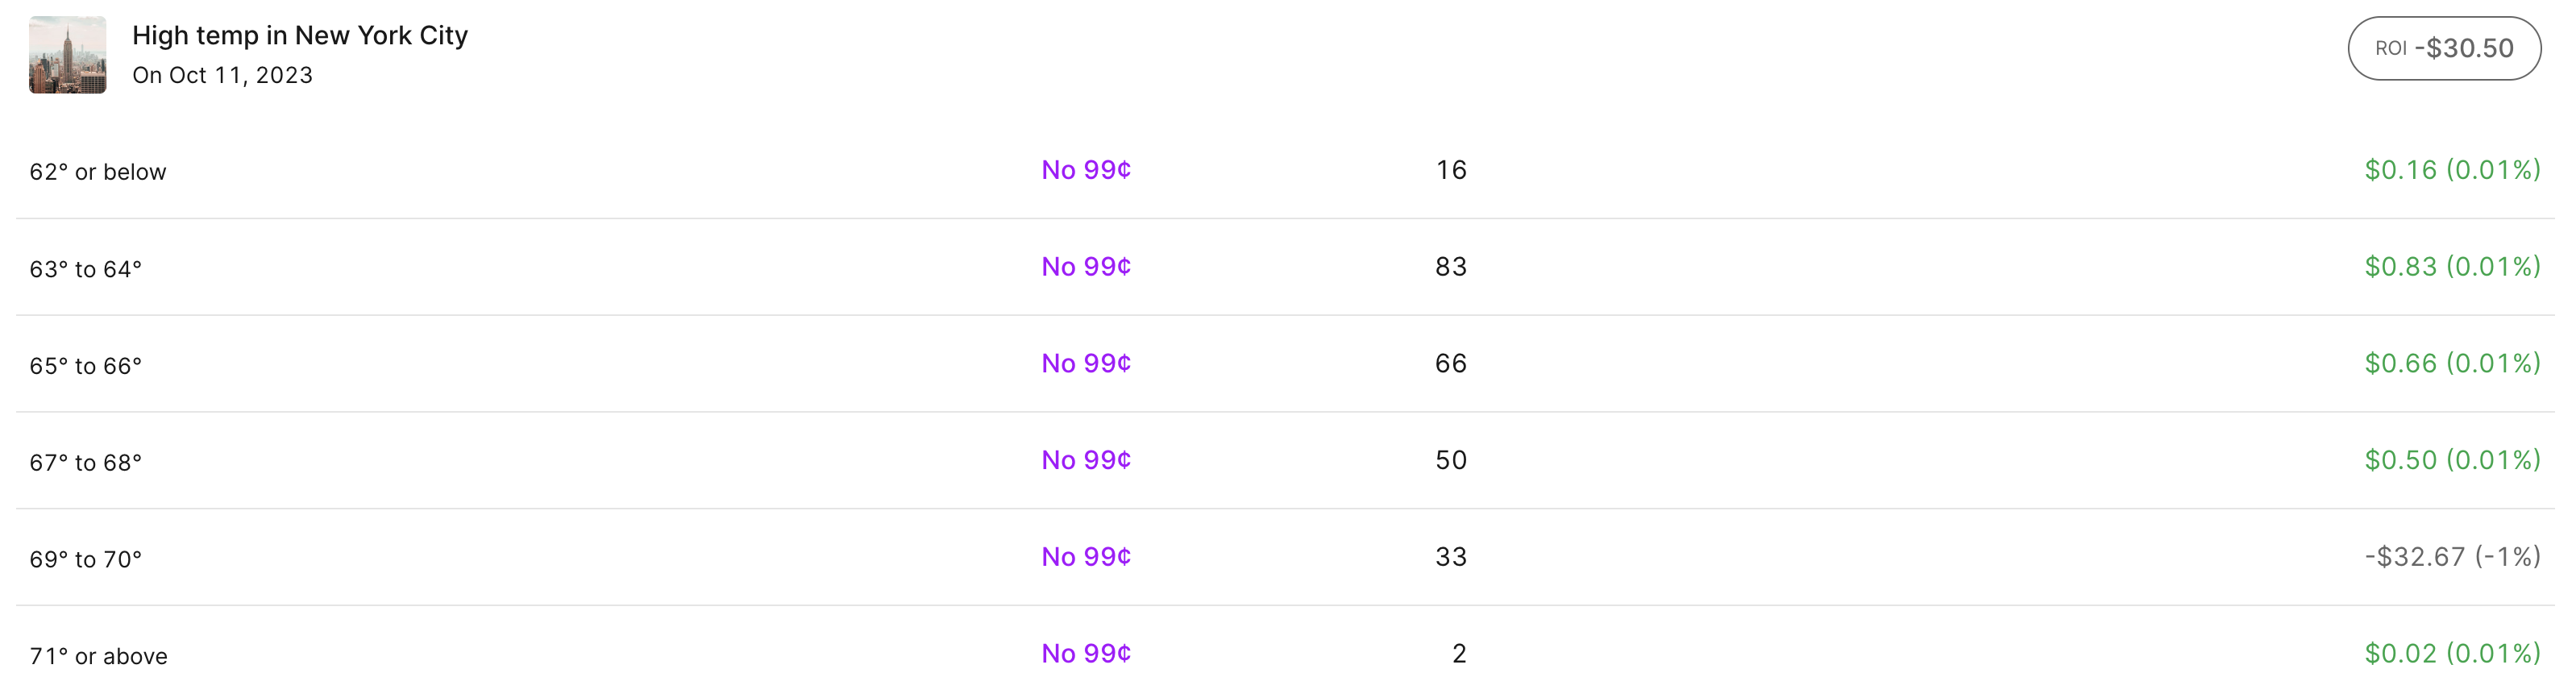

In [138]:
image_03 = Image("Screenshot/image_03.png")
display(image_03)

As a concluding step in the shared task, please find a screenshot of the culminated portfolio below.

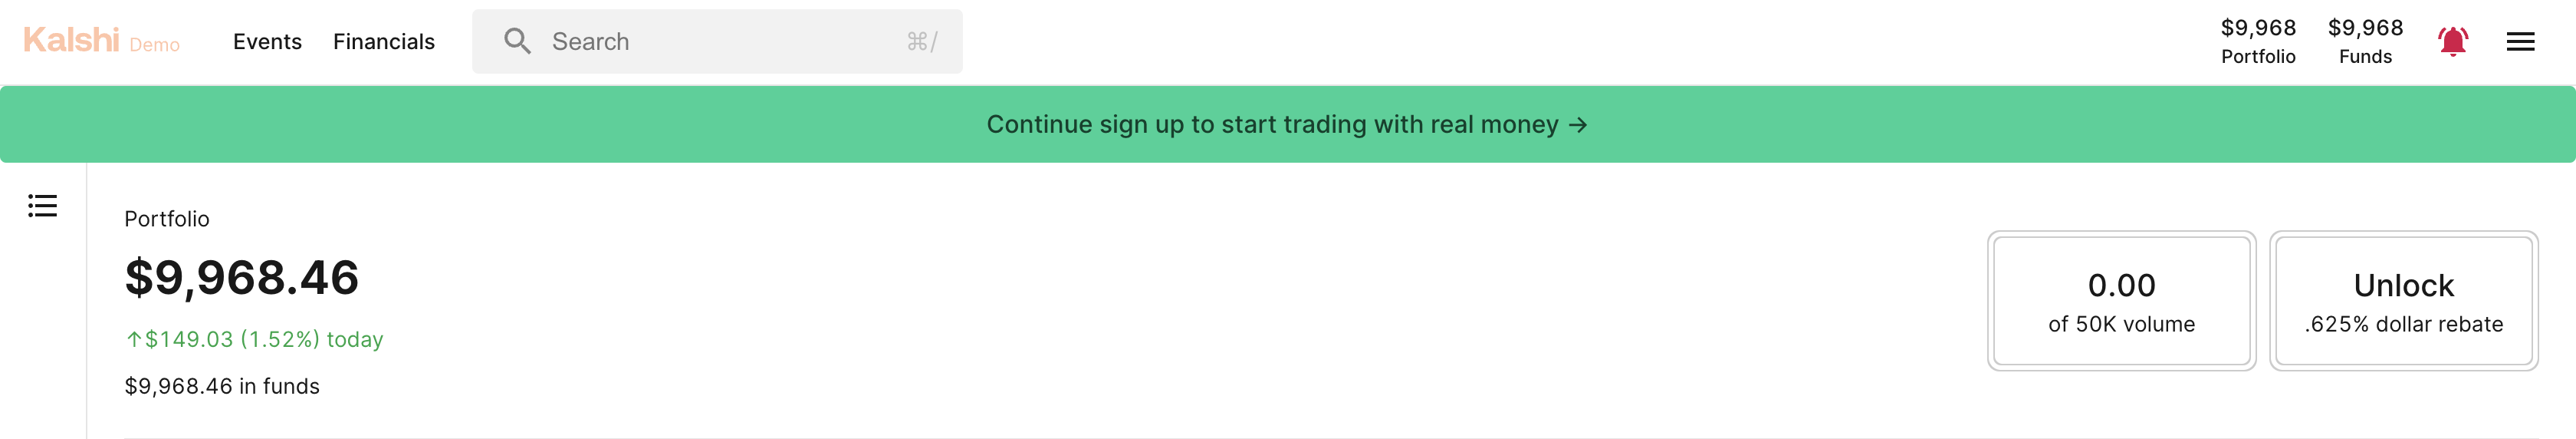

In [5]:
image_04 = Image("Screenshot/image_04.png")
display(image_04)

## **Learnings**

In summary, I gained valuable experience in building a machine learning model for temperature prediction and automating the process through the Kalshi API. I experimented with three distinct algorithms: Random Forest, Linear Regression, and XGBoost. Ultimately, I chose the XGBoost algorithm due to its superior performance. Furthermore, I computed nine additional features using rolling windows to enhance the performance. This experience reinforced the complexity of temperature prediction, with a significant portion of the effort dedicated to data scraping and cleaning. Fine-tuning the algorithm represented a smaller but essential part of the overall process.